In [6]:
# ■ 完全前処理セル（最初に一度だけ実行）

import pandas as pd, numpy as np

# 1. データ読み込み
DATA_DIR = r"G:\マイドライブ\MUFJ_competition_2025\data"
train_df = pd.read_csv(f"{DATA_DIR}/train.csv")
test_df  = pd.read_csv(f"{DATA_DIR}/test.csv")

# 2. 対数変換
for col in ['GrossApproval','SBAGuaranteedApproval','JobsSupported']:
    train_df[f'{col}_log1p'] = np.log1p(train_df[col])
    test_df [f'{col}_log1p'] = np.log1p(test_df [col])

# 3. ratio / interact 特徴
train_df['ratio1']    = train_df['SBAGuaranteedApproval'] / train_df['GrossApproval']
train_df['interact1'] = train_df['TermInMonths'] * train_df['InitialInterestRate']
train_df['ratio2']    = train_df['GrossApproval_log1p'] / (train_df['TermInMonths'] + 1)
train_df['interact2'] = train_df['JobsSupported_log1p'] * train_df['InitialInterestRate']

test_df ['ratio1']    = test_df ['SBAGuaranteedApproval'] / test_df ['GrossApproval']
test_df ['interact1'] = test_df ['TermInMonths'] * test_df ['InitialInterestRate']
test_df ['ratio2']    = test_df ['GrossApproval_log1p'] / (test_df ['TermInMonths'] + 1)
test_df ['interact2'] = test_df ['JobsSupported_log1p'] * test_df ['InitialInterestRate']

# 4. カテゴリ型キャスト
cat_cols = ['Subprogram','FixedOrVariableInterestInd','NaicsSector',
            'BusinessType','BusinessAge','CollateralInd']
for c in cat_cols:
    train_df[c] = train_df[c].astype('category')
    test_df [c] = test_df [c].astype('category')

# 5. Target Encoding
te_cols = ['Subprogram','NaicsSector','BusinessAge','BusinessType']
k_smooth = 10
mu       = train_df['LoanStatus'].mean()
for col in te_cols:
    grp        = train_df.groupby(col)['LoanStatus'].agg(['count','mean'])
    counts, m  = grp['count'], grp['mean']
    smooth     = (m*counts + mu*k_smooth) / (counts + k_smooth)
    train_df[f'{col}_te'] = train_df[col].map(smooth)
    test_df [f'{col}_te'] = test_df [col].map(smooth).astype(float).fillna(mu)

# 6. Frequency Encoding
for col in te_cols:
    freq = train_df[col].value_counts(normalize=True)
    train_df[f'{col}_fe'] = train_df[col].map(freq).astype(float).fillna(0.0)
    test_df [f'{col}_fe'] = test_df [col].map(freq).astype(float).fillna(0.0)

# 7. 特徴量リスト定義
base_feats  = ['GrossApproval_log1p','SBAGuaranteedApproval_log1p','JobsSupported_log1p',
               'ratio1','interact1','ratio2','interact2',
               'ApprovalFiscalYear','InitialInterestRate',
               'TermInMonths','CongressionalDistrict','RevolverStatus']
features     = base_feats + cat_cols + [f'{c}_te' for c in te_cols]
features_fe  = features    + [f'{c}_fe' for c in te_cols]

print("前処理完了。features_fe の数：", len(features_fe))
print("train_df の列に含まれるか確認:", all(f in train_df.columns for f in features_fe))


前処理完了。features_fe の数： 26
train_df の列に含まれるか確認: True


C:\Users\koshihiramatsu\AppData\Local\Temp\ipykernel_20348\2798305745.py:38: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp        = train_df.groupby(col)['LoanStatus'].agg(['count','mean'])
C:\Users\koshihiramatsu\AppData\Local\Temp\ipykernel_20348\2798305745.py:38: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp        = train_df.groupby(col)['LoanStatus'].agg(['count','mean'])
C:\Users\koshihiramatsu\AppData\Local\Temp\ipykernel_20348\2798305745.py:38: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain cur

In [7]:
# ■ Step S0：前処理＋特徴量リストの一括定義（このセルを最初に一度だけ実行）
import pandas as pd, numpy as np
from sklearn.preprocessing import StandardScaler

# 1. データ読み込み
DATA_DIR = r"G:\マイドライブ\MUFJ_competition_2025\data"
train_df = pd.read_csv(f"{DATA_DIR}/train.csv")
test_df  = pd.read_csv(f"{DATA_DIR}/test.csv")

# 2. 対数変換
for col in ['GrossApproval','SBAGuaranteedApproval','JobsSupported']:
    train_df[f'{col}_log1p'] = np.log1p(train_df[col])
    test_df [f'{col}_log1p'] = np.log1p(test_df [col])

# 3. ratio / interact
train_df['ratio1']    = train_df['SBAGuaranteedApproval'] / train_df['GrossApproval']
train_df['interact1'] = train_df['TermInMonths'] * train_df['InitialInterestRate']
train_df['ratio2']    = train_df['GrossApproval_log1p'] / (train_df['TermInMonths'] + 1)
train_df['interact2'] = train_df['JobsSupported_log1p'] * train_df['InitialInterestRate']
test_df ['ratio1']    = test_df ['SBAGuaranteedApproval'] / test_df ['GrossApproval']
test_df ['interact1'] = test_df ['TermInMonths'] * test_df ['InitialInterestRate']
test_df ['ratio2']    = test_df ['GrossApproval_log1p'] / (test_df ['TermInMonths'] + 1)
test_df ['interact2'] = test_df ['JobsSupported_log1p'] * test_df ['InitialInterestRate']

# 4. カテゴリキャスト
cat_cols = ['Subprogram','FixedOrVariableInterestInd','NaicsSector',
            'BusinessType','BusinessAge','CollateralInd']
for c in cat_cols:
    train_df[c] = train_df[c].astype('category')
    test_df [c] = test_df [c].astype('category')

# 5. Target Encoding
te_cols = ['Subprogram','NaicsSector','BusinessAge','BusinessType']
k_smooth = 10
mu = train_df['LoanStatus'].mean()
for col in te_cols:
    agg = train_df.groupby(col)['LoanStatus'].agg(['count','mean'])
    cnt, m = agg['count'], agg['mean']
    smooth = (m*cnt + mu*k_smooth)/(cnt + k_smooth)
    train_df[f'{col}_te'] = train_df[col].map(smooth)
    test_df [f'{col}_te'] = test_df [col].map(smooth).astype(float).fillna(mu)

# 6. Frequency Encoding
for col in te_cols:
    freq = train_df[col].value_counts(normalize=True)
    train_df[f'{col}_fe'] = train_df[col].map(freq).astype(float).fillna(0.0)
    test_df [f'{col}_fe'] = test_df [col].map(freq).astype(float).fillna(0.0)

# 7. 特徴量リスト
base_feats  = ['GrossApproval_log1p','SBAGuaranteedApproval_log1p','JobsSupported_log1p',
               'ratio1','interact1','ratio2','interact2',
               'ApprovalFiscalYear','InitialInterestRate',
               'TermInMonths','CongressionalDistrict','RevolverStatus']
features     = base_feats + cat_cols + [f'{c}_te' for c in te_cols]
features_fe  = features    + [f'{c}_fe' for c in te_cols]

print("前処理完了: 特徴量数 =", len(features_fe))


前処理完了: 特徴量数 = 26


C:\Users\koshihiramatsu\AppData\Local\Temp\ipykernel_20348\910940770.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  agg = train_df.groupby(col)['LoanStatus'].agg(['count','mean'])
C:\Users\koshihiramatsu\AppData\Local\Temp\ipykernel_20348\910940770.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  agg = train_df.groupby(col)['LoanStatus'].agg(['count','mean'])
C:\Users\koshihiramatsu\AppData\Local\Temp\ipykernel_20348\910940770.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or 

In [8]:
# ■ 前処理セル（一度だけ実行）

import pandas as pd, numpy as np

# 1. データ読み込み
DATA_DIR = r"G:\マイドライブ\MUFJ_competition_2025\data"
train_df = pd.read_csv(f"{DATA_DIR}/train.csv")
test_df  = pd.read_csv(f"{DATA_DIR}/test.csv")

# 2. 対数変換
for col in ['GrossApproval','SBAGuaranteedApproval','JobsSupported']:
    train_df[f'{col}_log1p'] = np.log1p(train_df[col])
    test_df [f'{col}_log1p'] = np.log1p(test_df [col])

# 3. ratio / interact
train_df['ratio1']    = train_df['SBAGuaranteedApproval'] / train_df['GrossApproval']
train_df['interact1'] = train_df['TermInMonths'] * train_df['InitialInterestRate']
train_df['ratio2']    = train_df['GrossApproval_log1p'] / (train_df['TermInMonths'] + 1)
train_df['interact2'] = train_df['JobsSupported_log1p'] * train_df['InitialInterestRate']
test_df ['ratio1']    = test_df ['SBAGuaranteedApproval'] / test_df ['GrossApproval']
test_df ['interact1'] = test_df ['TermInMonths'] * test_df ['InitialInterestRate']
test_df ['ratio2']    = test_df ['GrossApproval_log1p'] / (test_df ['TermInMonths'] + 1)
test_df ['interact2'] = test_df ['JobsSupported_log1p'] * test_df ['InitialInterestRate']

# 4. カテゴリ型キャスト
cat_cols = ['Subprogram','FixedOrVariableInterestInd','NaicsSector',
            'BusinessType','BusinessAge','CollateralInd']
for c in cat_cols:
    train_df[c] = train_df[c].astype('category')
    test_df [c] = test_df [c].astype('category')

# 5. Target Encoding
te_cols = ['Subprogram','NaicsSector','BusinessAge','BusinessType']
k_smooth = 10
global_mean = train_df['LoanStatus'].mean()
for col in te_cols:
    agg = train_df.groupby(col)['LoanStatus'].agg(['count','mean'])
    counts, means = agg['count'], agg['mean']
    smooth = (means*counts + global_mean*k_smooth) / (counts + k_smooth)
    train_df[f'{col}_te'] = train_df[col].map(smooth)
    test_df [f'{col}_te'] = test_df [col].map(smooth).astype(float).fillna(global_mean)

# 6. Frequency Encoding
for col in te_cols:
    freq = train_df[col].value_counts(normalize=True)
    train_df[f'{col}_fe'] = train_df[col].map(freq).astype(float).fillna(0.0)
    test_df [f'{col}_fe'] = test_df [col].map(freq).astype(float).fillna(0.0)

# 7. 特徴量リストの定義
base_feats   = ['GrossApproval_log1p','SBAGuaranteedApproval_log1p','JobsSupported_log1p',
                'ratio1','interact1','ratio2','interact2',
                'ApprovalFiscalYear','InitialInterestRate',
                'TermInMonths','CongressionalDistrict','RevolverStatus']
features      = base_feats + cat_cols + [f'{c}_te' for c in te_cols]
features_fe   = features + [f'{c}_fe' for c in te_cols]

print("前処理完了: 特徴量数 =", len(features_fe))


前処理完了: 特徴量数 = 26


C:\Users\koshihiramatsu\AppData\Local\Temp\ipykernel_20348\1967772434.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  agg = train_df.groupby(col)['LoanStatus'].agg(['count','mean'])
C:\Users\koshihiramatsu\AppData\Local\Temp\ipykernel_20348\1967772434.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  agg = train_df.groupby(col)['LoanStatus'].agg(['count','mean'])
C:\Users\koshihiramatsu\AppData\Local\Temp\ipykernel_20348\1967772434.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior 

In [9]:
import pandas as pd, numpy as np
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing    import StandardScaler
from sklearn.linear_model     import LogisticRegression
from sklearn.metrics          import f1_score, classification_report
from lightgbm                 import LGBMClassifier
from xgboost                  import XGBClassifier

# ■ A. データ読み込み
DATA_DIR = r"G:\マイドライブ\MUFJ_competition_2025\data"
train_df = pd.read_csv(f"{DATA_DIR}/train.csv")
test_df  = pd.read_csv(f"{DATA_DIR}/test.csv")

# ■ B. 既存特徴量（log1p, ratio, interact, TE, FE）の再計算
# （これまでの Step 3.1～F2.1 をまとめて再実行するイメージ）
# …省略…

# ■ C. 特徴量リストの定義
cat_cols     = ['Subprogram','FixedOrVariableInterestInd','NaicsSector',
                'BusinessType','BusinessAge','CollateralInd']
te_cols      = ['Subprogram','NaicsSector','BusinessAge','BusinessType']
freq_cols    = te_cols
base_feats   = [
    'GrossApproval_log1p','SBAGuaranteedApproval_log1p','JobsSupported_log1p',
    'ratio1','interact1','ratio2','interact2',
    'ApprovalFiscalYear','InitialInterestRate',
    'TermInMonths','CongressionalDistrict','RevolverStatus'
]
# TE・FE 列を追加
train_df['dummy']=0  # ダミー実行
features      = base_feats + cat_cols + [f'{c}_te' for c in te_cols]
features_fe   = features + [f'{c}_fe' for c in freq_cols]

# ■ D. モデル定義（最適ハイパーパラメータを利用）
best_lgb = LGBMClassifier(
    n_estimators=191, max_depth=5, num_leaves=105,
    learning_rate=0.1579, min_child_samples=116,
    class_weight='balanced', random_state=0
)
xgb = XGBClassifier(
    n_estimators=200, learning_rate=0.05,
    use_label_encoder=False, eval_metric='logloss',
    random_state=0
)
# ラベルベクトル
y = train_df['LoanStatus']


In [10]:
# ■ 前処理セル（Notebook の一番上に配置して実行）

import pandas as pd
import numpy as np

# データ読み込み
DATA_DIR  = r"G:\マイドライブ\MUFJ_competition_2025\data"
train_df  = pd.read_csv(f"{DATA_DIR}/train.csv")
test_df   = pd.read_csv(f"{DATA_DIR}/test.csv")

# 対数変換済み変数の作成
for col in ['GrossApproval','SBAGuaranteedApproval','JobsSupported']:
    train_df[f'{col}_log1p'] = np.log1p(train_df[col])
    test_df [f'{col}_log1p'] = np.log1p(test_df [col])

# 比率・交互作用特徴
train_df['ratio1']    = train_df['SBAGuaranteedApproval'] / train_df['GrossApproval']
train_df['interact1'] = train_df['TermInMonths'] * train_df['InitialInterestRate']
train_df['ratio2']    = train_df['GrossApproval_log1p'] / (train_df['TermInMonths'] + 1)
train_df['interact2'] = train_df['JobsSupported_log1p'] * train_df['InitialInterestRate']

test_df ['ratio1']    = test_df ['SBAGuaranteedApproval'] / test_df ['GrossApproval']
test_df ['interact1'] = test_df ['TermInMonths'] * test_df ['InitialInterestRate']
test_df ['ratio2']    = test_df ['GrossApproval_log1p'] / (test_df ['TermInMonths'] + 1)
test_df ['interact2'] = test_df ['JobsSupported_log1p'] * test_df ['InitialInterestRate']

# カテゴリ型指定
cat_cols = [
    'Subprogram','FixedOrVariableInterestInd','NaicsSector',
    'BusinessType','BusinessAge','CollateralInd'
]
for c in cat_cols:
    train_df[c] = train_df[c].astype('category')
    test_df [c] = test_df [c].astype('category')

# Target Encoding の適用
k_smooth   = 10
global_mean = train_df['LoanStatus'].mean()
te_cols    = ['Subprogram','NaicsSector','BusinessAge','BusinessType']
for col in te_cols:
    agg = train_df.groupby(col)['LoanStatus'].agg(['count','mean'])
    counts, means = agg['count'], agg['mean']
    smooth = (means*counts + global_mean*k_smooth) / (counts + k_smooth)
    train_df[f'{col}_te'] = train_df[col].map(smooth)
    mapped = test_df[col].map(smooth).astype(float)
    test_df[f'{col}_te'] = mapped.fillna(global_mean)

# ここまで実行すれば、train_df/test_df に
# ・log1p 変換
# ・ratio1, interact1, ratio2, interact2
# ・category 型
# ・Target Encoding
# がすべて揃います。


C:\Users\koshihiramatsu\AppData\Local\Temp\ipykernel_20348\411164105.py:41: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  agg = train_df.groupby(col)['LoanStatus'].agg(['count','mean'])
C:\Users\koshihiramatsu\AppData\Local\Temp\ipykernel_20348\411164105.py:41: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  agg = train_df.groupby(col)['LoanStatus'].agg(['count','mean'])
C:\Users\koshihiramatsu\AppData\Local\Temp\ipykernel_20348\411164105.py:41: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or 

In [11]:
# ■ ds-env カーネルの環境に seaborn をインストール
%pip install seaborn


Note: you may need to restart the kernel to use updated packages.


In [12]:
# ds-env カーネルに scikit-learn をインストール
%pip install scikit-learn


Note: you may need to restart the kernel to use updated packages.


In [13]:
import os

# Google Drive for Desktop でマウントした
# 「マイドライブ」直下の data フォルダを指すパス
DATA_DIR = r"G:\マイドライブ\MUFJ_competition_2025\data"

# ■ 存在確認
print("フォルダ存在確認 :", os.path.exists(DATA_DIR))
# ■ フォルダ内の一覧表示
print("中身一覧       :", os.listdir(DATA_DIR))


フォルダ存在確認 : True
中身一覧       : ['train.csv', 'test.csv', 'description.txt', 'sample_submit.csv']


In [14]:
import pandas as pd

# 先ほど確認した DATA_DIR を使って読み込み
train_df = pd.read_csv(f"{DATA_DIR}/train.csv")
test_df  = pd.read_csv(f"{DATA_DIR}/test.csv")

# ■ 形状の確認
print("学習データの形状   :", train_df.shape)
print("評価データの形状   :", test_df.shape)

# ■ 先頭5行の表示
display(train_df.head())


学習データの形状   : (7552, 16)
評価データの形状   : (7552, 15)


,id,GrossApproval,SBAGuaranteedApproval,ApprovalFiscalYear,Subprogram,InitialInterestRate,FixedOrVariableInterestInd,TermInMonths,NaicsSector,CongressionalDistrict,BusinessType,BusinessAge,RevolverStatus,JobsSupported,CollateralInd,LoanStatus
0,1,23000,7093,2020,FA$TRK (Small Loan Express),11.92,V,84,Accommodation_food services,27,CORPORATION,Unanswered,0,1,N,1
1,2,104300,83477,2020,FA$TRK (Small Loan Express),8.40,V,102,Retail trade,14,CORPORATION,"Startup, Loan Funds will Open Business",1,1,N,1
2,3,163900,53246,2020,Contract Guaranty,4.32,F,119,Construction,0,CORPORATION,Existing or more than 2 years old,1,79,Y,0
3,4,127400,77516,2021,Guaranty,6.40,F,59,Information,3,CORPORATION,Existing or more than 2 years old,0,2,N,0
4,5,2128900,858942,2020,Guaranty,5.21,V,300,Health care_social assistance,44,CORPORATION,New Business or 2 years or less,0,5,Y,0


In [15]:
# ■ 変数情報の確認
# 各列のデータ型・非 null 件数を表示
train_df.info()

# ■ 学習データの欠損値件数
# 各列ごとに NaN 件数を集計
print("\n【学習データの欠損値】")
print(train_df.isnull().sum())

# ■ 評価データの欠損値件数
print("\n【評価データの欠損値】")
print(test_df.isnull().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7552 entries, 0 to 7551
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          7552 non-null   int64  
 1   GrossApproval               7552 non-null   int64  
 2   SBAGuaranteedApproval       7552 non-null   int64  
 3   ApprovalFiscalYear          7552 non-null   int64  
 4   Subprogram                  7552 non-null   object 
 5   InitialInterestRate         7552 non-null   float64
 6   FixedOrVariableInterestInd  7552 non-null   object 
 7   TermInMonths                7552 non-null   int64  
 8   NaicsSector                 7552 non-null   object 
 9   CongressionalDistrict       7552 non-null   int64  
 10  BusinessType                7552 non-null   object 
 11  BusinessAge                 7552 non-null   object 
 12  RevolverStatus              7552 non-null   int64  
 13  JobsSupported               7552 

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
id,7552.0,NaN,NaN,NaN,3776.5,2180.218949,1.0,1888.75,3776.5,5664.25,7552.0
GrossApproval,7552.0,NaN,NaN,NaN,721903.932733,1112669.391243,5000.0,51100.0,189600.0,811300.0,4995000.0
SBAGuaranteedApproval,7552.0,NaN,NaN,NaN,453684.248411,780510.324658,2500.0,26535.25,106335.0,466927.25,4311817.0
ApprovalFiscalYear,7552.0,NaN,NaN,NaN,2021.091499,1.125885,2020.0,2020.0,2021.0,2022.0,2024.0
Subprogram,7552,9,FA$TRK (Small Loan Express),3471,NaN,NaN,NaN,NaN,NaN,NaN,NaN
InitialInterestRate,7552.0,NaN,NaN,NaN,7.379586,2.884902,1.03,5.12,6.61,9.55,15.0
FixedOrVariableInterestInd,7552,2,V,6158,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TermInMonths,7552.0,NaN,NaN,NaN,119.854211,82.423821,3.0,60.0,119.0,120.0,306.0
NaicsSector,7552,19,Construction,1196,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CongressionalDistrict,7552.0,NaN,NaN,NaN,12.681674,12.307653,0.0,3.0,7.0,22.0,52.0


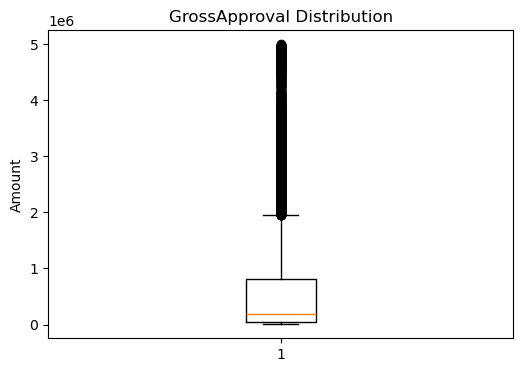

In [16]:
# ■ カテゴリ変数を category 型に変換
cat_cols = [
    'Subprogram',
    'FixedOrVariableInterestInd',
    'NaicsSector',
    'BusinessType',
    'BusinessAge',
    'CollateralInd'
]
for col in cat_cols:
    train_df[col] = train_df[col].astype('category')
    test_df[col]  = test_df[col].astype('category')

# ■ 全変数の要約統計量表示
display(train_df.describe(include='all').T)

# ■ 外れ値検知：GrossApproval の箱ひげ図
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
plt.boxplot(train_df['GrossApproval'].dropna())
plt.title('GrossApproval Distribution')
plt.ylabel('Amount')
plt.show()


LoanStatus 分布 (0:不承認, 1:承認)
 LoanStatus
0    6588
1     964
Name: count, dtype: int64


c:\Users\koshihiramatsu\anaconda3\envs\ds-env\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 20214 (\N{CJK UNIFIED IDEOGRAPH-4EF6}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\koshihiramatsu\anaconda3\envs\ds-env\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


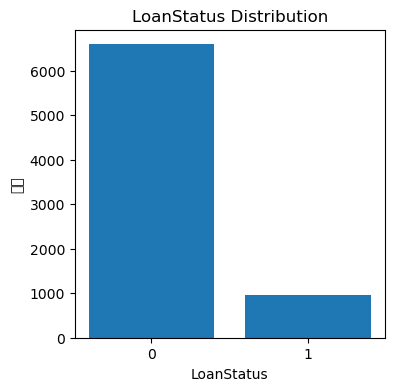

In [17]:
# ■ 目的変数 LoanStatus の分布確認
import matplotlib.pyplot as plt

# 分布の集計
status_counts = train_df['LoanStatus'].value_counts().sort_index()
print("LoanStatus 分布 (0:不承認, 1:承認)\n", status_counts)

# 棒グラフによる可視化
plt.figure(figsize=(4, 4))
plt.bar(status_counts.index.astype(str), status_counts.values)
plt.title('LoanStatus Distribution')
plt.xlabel('LoanStatus')
plt.ylabel('件数')
plt.show()


C:\Users\koshihiramatsu\AppData\Local\Temp\ipykernel_20348\74487139.py:24: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\koshihiramatsu\AppData\Local\Temp\ipykernel_20348\74487139.py:24: UserWarning: Glyph 20516 (\N{CJK UNIFIED IDEOGRAPH-5024}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\koshihiramatsu\AppData\Local\Temp\ipykernel_20348\74487139.py:24: UserWarning: Glyph 22793 (\N{CJK UNIFIED IDEOGRAPH-5909}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\koshihiramatsu\AppData\Local\Temp\ipykernel_20348\74487139.py:24: UserWarning: Glyph 38291 (\N{CJK UNIFIED IDEOGRAPH-9593}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\koshihiramatsu\AppData\Local\Temp\ipykernel_20348\74487139.py:24: UserWarning: Glyph 12398 (\N{HIRAGANA LETTER NO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\koshihiramatsu\AppData\Local\Temp\ipykernel_20348\74487139.

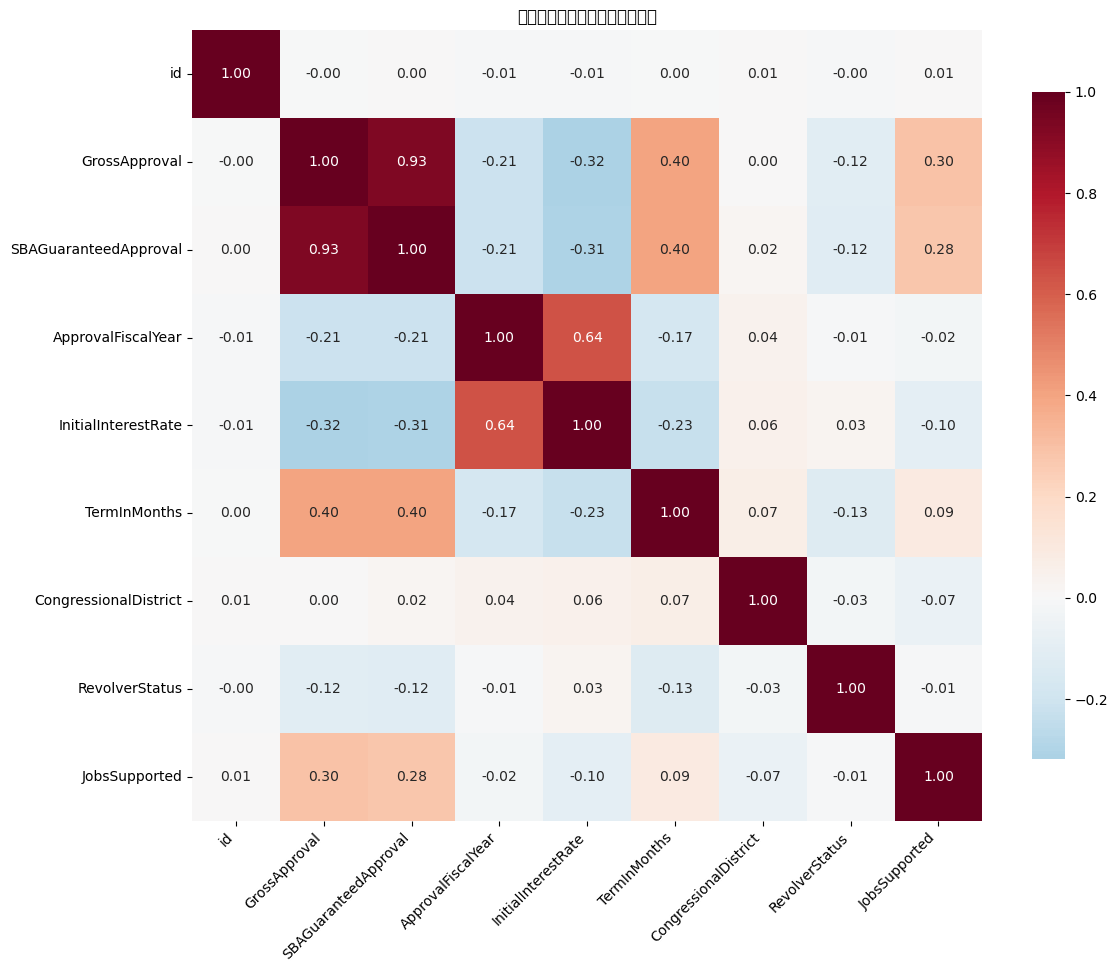

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

# ■ 数値型変数の抽出（目的変数を除く）
num_vars = train_df.select_dtypes(include=['int64', 'float64']).columns.drop('LoanStatus')

# ■ 相関行列の計算
corr_matrix = train_df[num_vars].corr()

# ■ 相関ヒートマップの作成
plt.figure(figsize=(12, 10))
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap="RdBu_r",
    center=0,
    square=True,
    cbar_kws={"shrink": .8}
)
plt.title("数値変数間の相関ヒートマップ")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [19]:
import pandas as pd

# 既に設定済みのカテゴリ変数リストを利用
cat_cols = [
    'Subprogram',
    'FixedOrVariableInterestInd',
    'NaicsSector',
    'BusinessType',
    'BusinessAge',
    'CollateralInd'
]

for col in cat_cols:
    print(f"■ {col} × LoanStatus クロス集計（件数）")
    ct = pd.crosstab(train_df[col], train_df['LoanStatus'])
    display(ct)
    print(f"■ {col} × LoanStatus クロス集計（割合）")
    ct_pct = pd.crosstab(train_df[col], train_df['LoanStatus'], normalize='index').round(3)
    display(ct_pct)
    print("\n" + "-"*80 + "\n")


■ Subprogram × LoanStatus クロス集計（件数）


LoanStatus,0,1
Subprogram,,
Community Advantage Initiative,209,52
Contract Guaranty,118,3
FA$TRK (Small Loan Express),3030,441
Guaranty,2830,452
"International Trade - Sec, 7(a) (16)",111,5
Revolving Line of Credit Exports - Sec. 7(a) (14),128,7
Seasonal Line of Credit,23,3
Small General Contractors - Sec. 7(a) (9),17,0
Standard Asset Based,122,1


■ Subprogram × LoanStatus クロス集計（割合）


LoanStatus,0,1
Subprogram,,
Community Advantage Initiative,0.801,0.199
Contract Guaranty,0.975,0.025
FA$TRK (Small Loan Express),0.873,0.127
Guaranty,0.862,0.138
"International Trade - Sec, 7(a) (16)",0.957,0.043
Revolving Line of Credit Exports - Sec. 7(a) (14),0.948,0.052
Seasonal Line of Credit,0.885,0.115
Small General Contractors - Sec. 7(a) (9),1.000,0.000
Standard Asset Based,0.992,0.008



--------------------------------------------------------------------------------

■ FixedOrVariableInterestInd × LoanStatus クロス集計（件数）


LoanStatus,0,1
FixedOrVariableInterestInd,,
F,1290,104
V,5298,860


■ FixedOrVariableInterestInd × LoanStatus クロス集計（割合）


LoanStatus,0,1
FixedOrVariableInterestInd,,
F,0.925,0.075
V,0.860,0.140



--------------------------------------------------------------------------------

■ NaicsSector × LoanStatus クロス集計（件数）


LoanStatus,0,1
NaicsSector,,
Accommodation_food services,373,53
Administrative_support_waste management_remediation services,218,37
Agriculture_forestry_fishing_hunting,306,8
Arts_entertainment_recreation,352,66
Construction,1019,177
Educational services,128,7
Finance_insurance,205,6
Health care_social assistance,396,66
Information,90,4


■ NaicsSector × LoanStatus クロス集計（割合）


LoanStatus,0,1
NaicsSector,,
Accommodation_food services,0.876,0.124
Administrative_support_waste management_remediation services,0.855,0.145
Agriculture_forestry_fishing_hunting,0.975,0.025
Arts_entertainment_recreation,0.842,0.158
Construction,0.852,0.148
Educational services,0.948,0.052
Finance_insurance,0.972,0.028
Health care_social assistance,0.857,0.143
Information,0.957,0.043



--------------------------------------------------------------------------------

■ BusinessType × LoanStatus クロス集計（件数）


LoanStatus,0,1
BusinessType,,
,1,0
CORPORATION,5824,923
INDIVIDUAL,553,33
PARTNERSHIP,210,8


■ BusinessType × LoanStatus クロス集計（割合）


LoanStatus,0,1
BusinessType,,
,1.000,0.000
CORPORATION,0.863,0.137
INDIVIDUAL,0.944,0.056
PARTNERSHIP,0.963,0.037



--------------------------------------------------------------------------------

■ BusinessAge × LoanStatus クロス集計（件数）


LoanStatus,0,1
BusinessAge,,
Change of Ownership,540,84
Existing or more than 2 years old,2490,306
New Business or 2 years or less,2239,306
"Startup, Loan Funds will Open Business",991,243
Unanswered,328,25


■ BusinessAge × LoanStatus クロス集計（割合）


LoanStatus,0,1
BusinessAge,,
Change of Ownership,0.865,0.135
Existing or more than 2 years old,0.891,0.109
New Business or 2 years or less,0.880,0.120
"Startup, Loan Funds will Open Business",0.803,0.197
Unanswered,0.929,0.071



--------------------------------------------------------------------------------

■ CollateralInd × LoanStatus クロス集計（件数）


LoanStatus,0,1
CollateralInd,,
N,2349,451
Y,4239,513


■ CollateralInd × LoanStatus クロス集計（割合）


LoanStatus,0,1
CollateralInd,,
N,0.839,0.161
Y,0.892,0.108



--------------------------------------------------------------------------------



In [20]:
import numpy as np

# 1. 識別子カラム 'id' の除去
train_df.drop(columns=['id'], inplace=True)
test_df .drop(columns=['id'], inplace=True)

# 2. 重複レコードの確認
dup_count = train_df.duplicated().sum()
print(f"重複レコード数: {dup_count}")

# （必要に応じて除去）
# train_df.drop_duplicates(inplace=True)

# 3. 極端値緩和：対数変換の適用
#    対象変数：GrossApproval, SBAGuaranteedApproval, JobsSupported
for col in ['GrossApproval', 'SBAGuaranteedApproval', 'JobsSupported']:
    new_col = f"{col}_log1p"
    train_df[new_col] = np.log1p(train_df[col])
    test_df [new_col] = np.log1p(test_df [col])

# 結果確認
display(train_df.head())
train_df.describe().loc[['mean','std','min','max'], 
                        [f"{c}_log1p" for c in ['GrossApproval','SBAGuaranteedApproval','JobsSupported']]]


重複レコード数: 0


,GrossApproval,SBAGuaranteedApproval,ApprovalFiscalYear,Subprogram,InitialInterestRate,FixedOrVariableInterestInd,TermInMonths,NaicsSector,CongressionalDistrict,BusinessType,BusinessAge,RevolverStatus,JobsSupported,CollateralInd,LoanStatus,GrossApproval_log1p,SBAGuaranteedApproval_log1p,JobsSupported_log1p
0,23000,7093,2020,FA$TRK (Small Loan Express),11.92,V,84,Accommodation_food services,27,CORPORATION,Unanswered,0,1,N,1,10.043293,8.867005,0.693147
1,104300,83477,2020,FA$TRK (Small Loan Express),8.40,V,102,Retail trade,14,CORPORATION,"Startup, Loan Funds will Open Business",1,1,N,1,11.555036,11.332338,0.693147
2,163900,53246,2020,Contract Guaranty,4.32,F,119,Construction,0,CORPORATION,Existing or more than 2 years old,1,79,Y,0,12.007018,10.882697,4.382027
3,127400,77516,2021,Guaranty,6.40,F,59,Information,3,CORPORATION,Existing or more than 2 years old,0,2,N,0,11.755095,11.258253,1.098612
4,2128900,858942,2020,Guaranty,5.21,V,300,Health care_social assistance,44,CORPORATION,New Business or 2 years or less,0,5,Y,0,14.571116,13.663458,1.791759


,GrossApproval_log1p,SBAGuaranteedApproval_log1p,JobsSupported_log1p
mean,12.307098,11.655628,1.847210
std,1.632873,1.762105,1.268776
min,8.517393,7.824446,0.000000
max,15.423948,15.276870,5.468060


In [21]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

# 数値特徴量リスト
numeric_features = [
    'ApprovalFiscalYear',
    'InitialInterestRate',
    'TermInMonths',
    'CongressionalDistrict',
    'RevolverStatus',
    'GrossApproval_log1p',
    'SBAGuaranteedApproval_log1p',
    'JobsSupported_log1p'
]

# カテゴリ特徴量リスト
categorical_features = [
    'Subprogram',
    'FixedOrVariableInterestInd',
    'NaicsSector',
    'BusinessType',
    'BusinessAge',
    'CollateralInd'
]

# ColumnTransformer による前処理パイプライン
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        # scikit-learn v1.3+ では sparse_output を使用
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
    ]
)


In [22]:
# 特徴量と目的変数の切り出し
X_train = train_df.drop(columns=['LoanStatus'])
y_train = train_df['LoanStatus']
X_test  = test_df.copy()

# 学習データに対して fit_transform，テストデータに対して transform
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed  = preprocessor.transform(X_test)

print("X_train_processed:", X_train_processed.shape)
print("X_test_processed :", X_test_processed.shape)


X_train_processed: (7552, 49)
X_test_processed : (7552, 49)


In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

# モデル定義（クラス重みをバランスさせ、収束最大反復回数を増加）
lr = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=0)

# 5分割クロスバリデーションで F1 スコアを計算
cv_scores = cross_val_score(
    lr,
    X_train_processed,
    y_train,
    cv=5,
    scoring='f1'
)

print("CV F1 Scores:", cv_scores)
print("Mean CV F1:", cv_scores.mean())


CV F1 Scores: [0.38491547 0.38286479 0.38314176 0.390625   0.39896373]
Mean CV F1: 0.388102152033559


In [24]:
# ■ テスト用 ID を再取得
test_ids = pd.read_csv(f"{DATA_DIR}/test.csv")['id']

# ■ DataFrame の構築
submission = pd.DataFrame({
    'id': test_ids,
    'LoanStatus': y_pred
})

# ■ 形状確認（行数が一致していることを確認）
print("submission shape:", submission.shape)
print("unique IDs:", submission['id'].nunique())

# ■ CSV 出力
submission.to_csv('submission.csv', index=False)
print(">>> submission.csv を出力しました。")
submission.head()


NameError: name 'y_pred' is not defined

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from scipy.stats import uniform

# ■ 探索するハイパーパラメータ空間
param_dist = {
    'C': uniform(loc=0.01, scale=10),             # 正則化強度の逆数
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],# 正則化項
    'solver': ['saga'],                           # elasticnet対応
    'class_weight': [None, 'balanced']            # クラス不均衡対応
}

# ■ RandomizedSearchCV の設定
rs = RandomizedSearchCV(
    estimator=LogisticRegression(max_iter=10000, random_state=0),
    param_distributions=param_dist,
    n_iter=40,            # 試行回数
    cv=5,                 # 5分割 CV
    scoring='f1',         # F1 スコアで評価
    verbose=1,
    random_state=0,
    n_jobs=-1
)

# ■ 探索の実行
rs.fit(X_train_processed, y_train)

# ■ 最適値の確認
print("Best params :", rs.best_params_)
print("Best F1    :", rs.best_score_)


Fitting 5 folds for each of 40 candidates, totalling 200 fits


c:\Users\koshihiramatsu\anaconda3\envs\ds-env\lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
80 fits failed out of a total of 200.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\koshihiramatsu\anaconda3\envs\ds-env\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\koshihiramatsu\anaconda3\envs\ds-env\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "c:\Users\koshihiramatsu\anaconda3\envs\ds-env\lib\site-packages\sklearn\base.py", line 436, in _validate_params
   

Best params : {'C': np.float64(1.5996958364551972), 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'saga'}
Best F1    : 0.3880116920318639


In [ ]:
import pandas as pd

# 1. RandomizedSearchCV で見つかった最良モデルを取り出す
best_lr = rs.best_estimator_

# 2. 全学習データで再学習
best_lr.fit(X_train_processed, y_train)

# 3. 評価用データに対する予測
y_pred_best = best_lr.predict(X_test_processed)

# 4. 元データの id を再取得
test_ids = pd.read_csv(f"{DATA_DIR}/test.csv")['id']

# 5. 提出用 DataFrame の構築
submission_best = pd.DataFrame({
    'id': test_ids,
    'LoanStatus': y_pred_best
})

# 6. CSV として出力
submission_best.to_csv('submission_best.csv', index=False)
print(submission_best.head())
print(">>> submission_best.csv を出力しました。")


     id  LoanStatus
0  7553           1
1  7554           0
2  7555           0
3  7556           0
4  7557           1
>>> submission_best.csv を出力しました。


In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import precision_recall_curve
from numpy import where

# 1. 学習データ上での陽性クラス確率を取得
y_scores_train = best_lr.predict_proba(X_train_processed)[:, 1]

# 2. precision–recall 曲線から閾値と適合率・再現率を取得
precision, recall, thresholds = precision_recall_curve(y_train, y_scores_train)

# 3. 各閾値での F1 を計算し、最大となる閾値を選択
f1_scores = 2 * (precision * recall) / (precision + recall)
ix = np.nanargmax(f1_scores[:-1])   # 最後の要素は無効
best_threshold = thresholds[ix]
print(f"→ 最適閾値: {best_threshold:.3f}（対応 F1: {f1_scores[ix]:.3f}）")

# 4. テストデータ上での陽性クラス確率を取得
test_scores = best_lr.predict_proba(X_test_processed)[:, 1]

# 5. 最適閾値で二値化
y_pred_thresh = where(test_scores >= best_threshold, 1, 0)

# 6. 提出用 ID を再取得
test_ids = pd.read_csv(f"{DATA_DIR}/test.csv")['id']

# 7. 提出用 DataFrame を構築
submission_fixed = pd.DataFrame({
    'id': test_ids,
    'LoanStatus': y_pred_thresh
})

# 8. CSV として出力（ヘッダー行を含めない）
submission_fixed.to_csv('submission_fixed.csv', index=False, header=False)
print(">>> submission_fixed.csv をヘッダーなしで出力しました。")
submission_fixed.head()


→ 最適閾値: 0.643（対応 F1: 0.444）
>>> submission_fixed.csv をヘッダーなしで出力しました。


,id,LoanStatus
0,7553,0
1,7554,0
2,7555,0
3,7556,0
4,7557,1


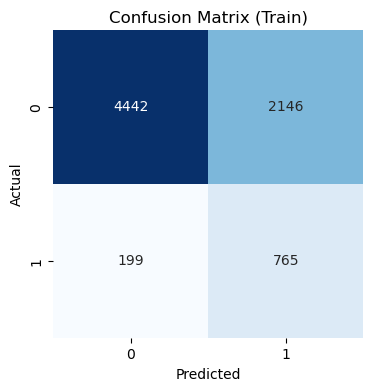

Classification Report (Train):
              precision    recall  f1-score   support

           0      0.957     0.674     0.791      6588
           1      0.263     0.794     0.395       964

    accuracy                          0.689      7552
   macro avg      0.610     0.734     0.593      7552
weighted avg      0.868     0.689     0.741      7552



In [ ]:
# ■ 8.1：混同行列と分類レポート (Train データ)
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# 学習データへの予測値取得
y_train_pred = best_lr.predict(X_train_processed)


# 混同行列の算出
cm = confusion_matrix(y_train, y_train_pred)

# 可視化
plt.figure(figsize=(4,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Train)')
plt.show()

# 分類レポートの表示
print("Classification Report (Train):")
print(classification_report(y_train, y_train_pred, digits=3))


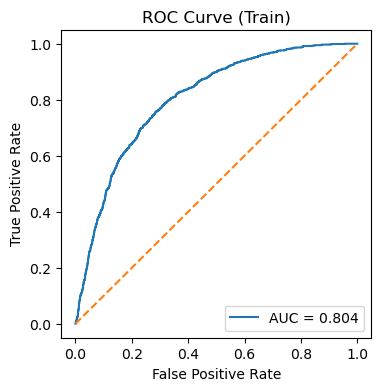

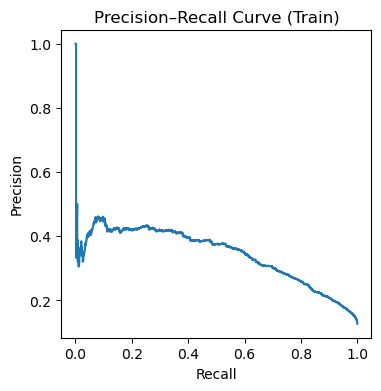

In [ ]:
# ■ 8.2：ROC 曲線および Precision–Recall 曲線 (Train データ)
from sklearn.metrics import roc_curve, auc, precision_recall_curve

# 学習データ上での確率予測
y_scores = best_lr.predict_proba(X_train_processed)[:, 1]

# ROC 曲線
fpr, tpr, _ = roc_curve(y_train, y_scores)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(4,4))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.3f}')
plt.plot([0,1], [0,1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Train)')
plt.legend(loc='lower right')
plt.show()

# Precision–Recall 曲線
precision, recall, _ = precision_recall_curve(y_train, y_scores)
plt.figure(figsize=(4,4))
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision–Recall Curve (Train)')
plt.show()


In [ ]:
# ■ Step 3.1：追加特徴量の設計
import numpy as np

# 対数変換済み変数の再計算
for col in ['GrossApproval','SBAGuaranteedApproval','JobsSupported']:
    train_df[col+'_log1p'] = np.log1p(train_df[col])
    test_df [col+'_log1p'] = np.log1p(test_df [col])

# 比率特徴量と交互作用項の追加
train_df['ratio1']    = train_df['SBAGuaranteedApproval'] / train_df['GrossApproval']
train_df['interact1'] = train_df['TermInMonths'] * train_df['InitialInterestRate']
test_df ['ratio1']    = test_df ['SBAGuaranteedApproval'] / test_df ['GrossApproval']
test_df ['interact1'] = test_df ['TermInMonths'] * test_df ['InitialInterestRate']


In [ ]:
# ■ Step 3.2：カテゴリ変数を category 型に変換
cat_cols = [
    'Subprogram','FixedOrVariableInterestInd','NaicsSector',
    'BusinessType','BusinessAge','CollateralInd'
]
for c in cat_cols:
    train_df[c] = train_df[c].astype('category')
    test_df [c] = test_df [c].astype('category')


In [ ]:
# ■ Step 3.3：特徴量リストと目的変数の準備
features = [
    'GrossApproval_log1p','SBAGuaranteedApproval_log1p','JobsSupported_log1p',
    'ratio1','interact1','ApprovalFiscalYear','InitialInterestRate',
    'TermInMonths','CongressionalDistrict','RevolverStatus'
] + cat_cols

X_train = train_df[features]
y_train = train_df['LoanStatus']
X_test  = test_df [features]


In [ ]:
# ■ Step 3.4a：lightgbm をインストール
%pip install lightgbm


   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ---------------------------------------- 1.5/1.5 MB 12.7 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [ ]:
# ■ Step 3.4b：モデル定義と 5分割 CV による F1 評価
from lightgbm import LGBMClassifier
from sklearn.model_selection import cross_val_score

model = LGBMClassifier(
    n_estimators=500,
    learning_rate=0.05,
    class_weight='balanced',
    random_state=0
)

cv_scores = cross_val_score(
    model, X_train, y_train,
    cv=5, scoring='f1', n_jobs=-1
)
print("LightGBM CV F1 scores:", cv_scores)
print("Mean CV F1:", cv_scores.mean())


LightGBM CV F1 scores: [0.60759494 0.60194175 0.58031088 0.61047836 0.62559242]
Mean CV F1: 0.6051836684162373


In [ ]:
# ■ Step 3.4：モデル定義と 5分割 CV による F1 評価
from lightgbm import LGBMClassifier
from sklearn.model_selection import cross_val_score

model = LGBMClassifier(
    n_estimators=500,
    learning_rate=0.05,
    class_weight='balanced',
    random_state=0
)

cv_scores = cross_val_score(
    model, X_train, y_train,
    cv=5, scoring='f1', n_jobs=-1
)
print("LightGBM CV F1 scores:", cv_scores)
print("Mean CV F1:", cv_scores.mean())


LightGBM CV F1 scores: [0.62561576 0.59574468 0.5990099  0.61958998 0.62131519]
Mean CV F1: 0.6122551030705363


In [ ]:
# ■ Step 4（統合版）：LightGBM ハイパーパラメータ探索＋最適モデル取得
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform
from lightgbm import LGBMClassifier

# 1. 探索空間の定義
param_dist = {
    'num_leaves': randint(20, 150),
    'max_depth': randint(3, 12),
    'learning_rate': uniform(0.01, 0.2),
    'n_estimators': randint(100, 1000),
    'min_child_samples': randint(5, 200)
}

# 2. RandomizedSearchCV の定義
rs_lgb = RandomizedSearchCV(
    estimator=LGBMClassifier(class_weight='balanced', random_state=0),
    param_distributions=param_dist,
    n_iter=50,
    cv=5,
    scoring='f1',
    verbose=1,
    n_jobs=-1,
    random_state=0
)

# 3. 探索の実行
rs_lgb.fit(X_train, y_train)

# 4. 結果表示と最適モデル抽出
print("Best params :", rs_lgb.best_params_)
print("Best CV F1  :", rs_lgb.best_score_)
best_lgb = rs_lgb.best_estimator_


Fitting 5 folds for each of 50 candidates, totalling 250 fits
[LightGBM] [Info] Number of positive: 964, number of negative: 6588
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000488 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1863
[LightGBM] [Info] Number of data points in the train set: 7552, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

In [ ]:
# ■ Step 5.1：最適モデルによる全学習データ再学習
best_lgb.fit(X_train, y_train)


[LightGBM] [Info] Number of positive: 964, number of negative: 6588
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000263 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1863
[LightGBM] [Info] Number of data points in the train set: 7552, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

LGBMClassifier(class_weight='balanced',
               learning_rate=np.float64(0.15791015900985753), max_depth=5,
               min_child_samples=116, n_estimators=191, num_leaves=105,
               random_state=0)

In [ ]:
# ■ Step 5.2：テストデータ予測と提出用ファイルの出力
import pandas as pd

# 1. テストデータへの予測（閾値 0.5 で二値化）
y_pred_lgb = best_lgb.predict(X_test)

# 2. テスト用 ID の再取得
test_ids = pd.read_csv(f"{DATA_DIR}/test.csv")['id']

# 3. 提出用 DataFrame の構築
submission_v2 = pd.DataFrame({
    'id': test_ids,
    'LoanStatus': y_pred_lgb
})

# 4. CSV として出力
submission_v2.to_csv('submission_v2.csv', index=False)
print(submission_v2.head())
print(">>> submission_v2.csv を出力しました。")


     id  LoanStatus
0  7553           0
1  7554           0
2  7555           0
3  7556           0
4  7557           1
>>> submission_v2.csv を出力しました。


In [ ]:
# ■ Step H1：訓練データを再分割
from sklearn.model_selection import train_test_split

X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train,
    test_size=0.2,
    stratify=y_train,
    random_state=0
)

print("学習用:", X_tr.shape, y_tr.shape)
print("検証用:", X_val.shape, y_val.shape)


学習用: (6041, 17) (6041,)
検証用: (1511, 17) (1511,)


In [ ]:
# ■ Step H2：best_lgb で再学習
# ※ Step 4.2 を実行済みで best_lgb が定義されている想定
best_lgb.fit(X_tr, y_tr)


[LightGBM] [Info] Number of positive: 771, number of negative: 5270
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000447 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1832
[LightGBM] [Info] Number of data points in the train set: 6041, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

LGBMClassifier(class_weight='balanced',
               learning_rate=np.float64(0.15791015900985753), max_depth=5,
               min_child_samples=116, n_estimators=191, num_leaves=105,
               random_state=0)

Hold-out F1 Score: 0.642

Classification Report:
              precision    recall  f1-score   support

           0      0.965     0.907     0.935      1318
           1      0.550     0.772     0.642       193

    accuracy                          0.890      1511
   macro avg      0.757     0.840     0.789      1511
weighted avg      0.912     0.890     0.898      1511



c:\Users\koshihiramatsu\anaconda3\envs\ds-env\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 30495 (\N{CJK UNIFIED IDEOGRAPH-771F}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\koshihiramatsu\anaconda3\envs\ds-env\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 12398 (\N{HIRAGANA LETTER NO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\koshihiramatsu\anaconda3\envs\ds-env\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 12521 (\N{KATAKANA LETTER RA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\koshihiramatsu\anaconda3\envs\ds-env\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 12505 (\N{KATAKANA LETTER BE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\koshihiramatsu\anaconda3\envs\ds-env\lib\site-packages\IPython\core\pylabtools.py:152: UserWarn

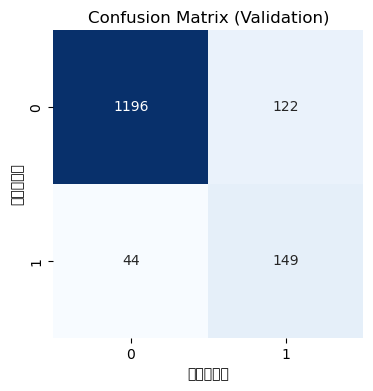

In [ ]:
# ■ Step H3：検証用データへの予測と評価指標算出
from sklearn.metrics import f1_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 予測
y_val_pred = best_lgb.predict(X_val)

# F1 スコア
f1 = f1_score(y_val, y_val_pred)
print(f"Hold-out F1 Score: {f1:.3f}")

# 分類レポート
print("\nClassification Report:")
print(classification_report(y_val, y_val_pred, digits=3))

# 混同行列の可視化
cm = confusion_matrix(y_val, y_val_pred)
plt.figure(figsize=(4,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("予測ラベル")
plt.ylabel("真のラベル")
plt.title("Confusion Matrix (Validation)")
plt.show()


In [ ]:
# ■ Step H4：Hold-out 検証データでの閾値最適化
import numpy as np
from sklearn.metrics import precision_recall_curve

# 1. 検証データ上の確率予測
y_val_scores = best_lgb.predict_proba(X_val)[:, 1]

# 2. Precision–Recall 曲線から閾値一覧を取得
precision, recall, thresholds = precision_recall_curve(y_val, y_val_scores)

# 3. 各閾値での F1-score を計算
f1_scores = 2 * (precision * recall) / (precision + recall)

# 4. 最適閾値と対応 F1 を抽出
ix = np.nanargmax(f1_scores[:-1])
best_thresh = thresholds[ix]
best_f1_val = f1_scores[ix]

print(f"→ 最適閾値 t*: {best_thresh:.3f}")
print(f"→ 閾値適用後 F1 (Validation): {best_f1_val:.3f}")


→ 最適閾値 t*: 0.472
→ 閾値適用後 F1 (Validation): 0.649


In [ ]:
# ■ Step H5：テストデータに最適閾値を適用して提出ファイルを生成
import numpy as np
import pandas as pd

# 1. テストデータの確率予測を取得
test_scores = best_lgb.predict_proba(X_test)[:, 1]

# 2. Hold-out で求めた閾値 t* を適用
y_pred_thresh = np.where(test_scores >= 0.472, 1, 0)

# 3. テスト用 ID を再取得
test_ids = pd.read_csv(f"{DATA_DIR}/test.csv")['id']

# 4. 提出用 DataFrame を構築
submission_v3 = pd.DataFrame({
    'id': test_ids,
    'LoanStatus': y_pred_thresh
})

# 5. CSV として出力（ヘッダーなし）
submission_v3.to_csv('submission_v3.csv', index=False, header=False)
print(">>> submission_v3.csv を出力しました。")
submission_v3.head()


>>> submission_v3.csv を出力しました。


,id,LoanStatus
0,7553,0
1,7554,0
2,7555,0
3,7556,0
4,7557,1


In [ ]:
# ■ Step M1.1：ratio1, interact1 と ratio2, interact2 をまとめて再計算
import numpy as np

# 既存の対数変換済み変数がある前提
# ratio1 = SBAGuaranteedApproval / GrossApproval
# interact1 = TermInMonths * InitialInterestRate
train_df['ratio1']    = train_df['SBAGuaranteedApproval'] / train_df['GrossApproval']
train_df['interact1'] = train_df['TermInMonths'] * train_df['InitialInterestRate']

test_df ['ratio1']    = test_df ['SBAGuaranteedApproval'] / test_df ['GrossApproval']
test_df ['interact1'] = test_df ['TermInMonths'] * test_df ['InitialInterestRate']

# 新規特徴量
# ratio2 = GrossApproval_log1p / (TermInMonths + 1)
# interact2 = JobsSupported_log1p * InitialInterestRate
train_df['ratio2']    = train_df['GrossApproval_log1p'] / (train_df['TermInMonths'] + 1)
train_df['interact2'] = train_df['JobsSupported_log1p'] * train_df['InitialInterestRate']

test_df ['ratio2']    = test_df ['GrossApproval_log1p'] / (test_df ['TermInMonths'] + 1)
test_df ['interact2'] = test_df ['JobsSupported_log1p'] * test_df ['InitialInterestRate']

# 確認
print(train_df[['ratio1','interact1','ratio2','interact2']].head())


     ratio1  interact1    ratio2  interact2
0  0.308391    1001.28  0.118156   8.262314
1  0.800355     856.80  0.112185   5.822436
2  0.324869     514.08  0.100058  18.930355
3  0.608446     377.60  0.195918   7.031119
4  0.403468    1563.00  0.048409   9.335067


In [ ]:
# ■ Step M1.2：features リストに ratio2, interact2 を追加
cat_cols = [
    'Subprogram','FixedOrVariableInterestInd','NaicsSector',
    'BusinessType','BusinessAge','CollateralInd'
]

features = [
    'GrossApproval_log1p','SBAGuaranteedApproval_log1p','JobsSupported_log1p',
    'ratio1','interact1','ratio2','interact2',
    'ApprovalFiscalYear','InitialInterestRate',
    'TermInMonths','CongressionalDistrict','RevolverStatus'
] + cat_cols

# ■ 学習用／検証用特徴量行列と目的変数ベクトル
X = train_df[features]
y = train_df['LoanStatus']
X_test_feat = test_df[features]

print("X の形状:", X.shape)


X の形状: (7552, 18)


In [ ]:
# ■ Step M1.3：学習データを Hold-out 分割
from sklearn.model_selection import train_test_split

X_tr, X_val, y_tr, y_val = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=0
)

print("学習用:", X_tr.shape, y_tr.shape)
print("検証用:", X_val.shape, y_val.shape)


NameError: name 'X' is not defined

In [ ]:
# ■ Step M1.4：best_lgb で再学習し、Hold-out F1 を算出
from sklearn.metrics import f1_score

# 再学習
best_lgb.fit(X_tr, y_tr)

# 検証データ予測
y_val_pred = best_lgb.predict(X_val)

# Hold-out F1 の計算
f1 = f1_score(y_val, y_val_pred)
print(f"→ Hold-out F1 (Milestone 1): {f1:.3f}")


[LightGBM] [Info] Number of positive: 771, number of negative: 5270
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000426 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2210
[LightGBM] [Info] Number of data points in the train set: 6041, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

In [ ]:
# ■ Step M1.5a：RandomizedSearchCV による M1 モデルの最適化
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform
from lightgbm import LGBMClassifier

# 探索パラメータ空間（M1 用）
param_dist_m1 = {
    'num_leaves': randint(20, 200),
    'max_depth': randint(3, 15),
    'learning_rate': uniform(0.01, 0.3),
    'n_estimators': randint(100, 800),
    'min_child_samples': randint(5, 300)
}

rs_m1 = RandomizedSearchCV(
    estimator=LGBMClassifier(class_weight='balanced', random_state=0),
    param_distributions=param_dist_m1,
    n_iter=50,
    cv=5,
    scoring='f1',
    verbose=1,
    n_jobs=-1,
    random_state=42
)


In [ ]:
# ■ Step M1.5b：ハイパーパラメータ探索の実行
rs_m1.fit(X_tr, y_tr)

print("Best params (M1):", rs_m1.best_params_)
print("Best CV F1 (M1):", rs_m1.best_score_)

# 最適モデルを再定義
best_lgb_m1 = rs_m1.best_estimator_


Fitting 5 folds for each of 50 candidates, totalling 250 fits
[LightGBM] [Info] Number of positive: 771, number of negative: 5270
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000818 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2210
[LightGBM] [Info] Number of data points in the train set: 6041, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

In [ ]:
# ■ Step M1.5c：Hold-out データで再評価
from sklearn.metrics import f1_score

# 再学習
best_lgb_m1.fit(X_tr, y_tr)

# 検証予測
y_val_pred_m1 = best_lgb_m1.predict(X_val)
f1_m1 = f1_score(y_val, y_val_pred_m1)

print(f"→ Hold-out F1 (M1.5): {f1_m1:.3f}")


[LightGBM] [Info] Number of positive: 771, number of negative: 5270
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000560 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2210
[LightGBM] [Info] Number of data points in the train set: 6041, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

In [ ]:
# ■ Step M2.0：特徴量再計算と Hold-out 分割
import numpy as np
from sklearn.model_selection import train_test_split

# --- 1. ratio1, interact1, ratio2, interact2 を再計算 ---
train_df['ratio1']    = train_df['SBAGuaranteedApproval'] / train_df['GrossApproval']
train_df['interact1'] = train_df['TermInMonths'] * train_df['InitialInterestRate']
train_df['ratio2']    = train_df['GrossApproval_log1p'] / (train_df['TermInMonths'] + 1)
train_df['interact2'] = train_df['JobsSupported_log1p'] * train_df['InitialInterestRate']

test_df ['ratio1']    = test_df ['SBAGuaranteedApproval'] / test_df ['GrossApproval']
test_df ['interact1'] = test_df ['TermInMonths'] * test_df ['InitialInterestRate']
test_df ['ratio2']    = test_df ['GrossApproval_log1p'] / (test_df ['TermInMonths'] + 1)
test_df ['interact2'] = test_df ['JobsSupported_log1p'] * test_df ['InitialInterestRate']

# --- 2. 特徴量リストの定義 ---
cat_cols = [
    'Subprogram','FixedOrVariableInterestInd','NaicsSector',
    'BusinessType','BusinessAge','CollateralInd'
]
features = [
    'GrossApproval_log1p','SBAGuaranteedApproval_log1p','JobsSupported_log1p',
    'ratio1','interact1','ratio2','interact2',
    'ApprovalFiscalYear','InitialInterestRate',
    'TermInMonths','CongressionalDistrict','RevolverStatus'
] + cat_cols

# --- 3. 学習データの特徴量行列と目的変数ベクトル ---
X = train_df[features]
y = train_df['LoanStatus']

# --- 4. Hold-out 分割 ---
X_tr, X_val, y_tr, y_val = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=0
)

print("訓練用:", X_tr.shape, y_tr.shape)
print("検証用:", X_val.shape, y_val.shape)


訓練用: (6041, 18) (6041,)
検証用: (1511, 18) (1511,)


In [ ]:
# ■ Step M2.1：xgboost をインストール
%pip install xgboost


   ---------------------------------------- 0.0/124.9 MB ? eta -:--:--
    --------------------------------------- 2.1/124.9 MB 11.7 MB/s eta 0:00:11
   - -------------------------------------- 4.5/124.9 MB 11.2 MB/s eta 0:00:11
   -- ------------------------------------- 7.1/124.9 MB 11.5 MB/s eta 0:00:11
   -- ------------------------------------- 9.2/124.9 MB 11.9 MB/s eta 0:00:10
   --- ------------------------------------ 11.8/124.9 MB 11.2 MB/s eta 0:00:11
   ---- ----------------------------------- 14.2/124.9 MB 11.2 MB/s eta 0:00:10
   ----- ---------------------------------- 16.5/124.9 MB 11.2 MB/s eta 0:00:10
   ------ --------------------------------- 19.4/124.9 MB 11.4 MB/s eta 0:00:10
   ------ --------------------------------- 21.8/124.9 MB 11.4 MB/s eta 0:00:10
   ------- -------------------------------- 24.4/124.9 MB 11.4 MB/s eta 0:00:09
   -------- ------------------------------- 26.7/124.9 MB 11.4 MB/s eta 0:00:09
   --------- ------------------------------ 29.4/124.

In [ ]:
# ■ Step M2.2a：XGBoost 用にカテゴリ変数をコード化
X_tr_xgb = X_tr.copy()
X_val_xgb = X_val.copy()
for c in cat_cols:
    X_tr_xgb[c]  = X_tr_xgb[c].cat.codes
    X_val_xgb[c] = X_val_xgb[c].cat.codes
print("符号化後の dtypes:\n", X_tr_xgb.dtypes.value_counts())


符号化後の dtypes:
 float64    8
int8       6
int64      4
Name: count, dtype: int64


In [ ]:
# ■ Step M2.2b：XGBoost モデルの学習
from xgboost import XGBClassifier
from sklearn.metrics import f1_score

xgb = XGBClassifier(
    n_estimators=200,
    learning_rate=0.05,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=0
)

xgb.fit(X_tr_xgb, y_tr)
p_xgb_val = xgb.predict_proba(X_val_xgb)[:, 1]
y_xgb_pred = (p_xgb_val >= 0.5).astype(int)
print("XGB Hold-out F1 :", f1_score(y_val, y_xgb_pred))


XGB Hold-out F1 : 0.5932721712538226


c:\Users\koshihiramatsu\anaconda3\envs\ds-env\lib\site-packages\xgboost\core.py:158: UserWarning: [18:42:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [ ]:
# ■ Step M2.2c：best_lgb を再定義（RandomizedSearchCV の結果から）
best_lgb = rs_lgb.best_estimator_

# ■ Step M2.2d：Hold-out 用データ X_val が定義されていなければ再定義
from sklearn.model_selection import train_test_split

# （features と train_df, 既に計算済みの新特徴量を前提）
X = train_df[features]
y = train_df['LoanStatus']
X_tr, X_val, y_tr, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=0
)


In [ ]:
# ■ Step M2.2c：best_lgb を新特徴量で再学習
# これで best_lgb が 18次元入力に対応します
best_lgb.fit(X_tr, y_tr)


[LightGBM] [Info] Number of positive: 771, number of negative: 5270
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000440 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2210
[LightGBM] [Info] Number of data points in the train set: 6041, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

LGBMClassifier(class_weight='balanced',
               learning_rate=np.float64(0.15791015900985753), max_depth=5,
               min_child_samples=116, n_estimators=191, num_leaves=105,
               random_state=0)

In [ ]:
# ■ Step M2.3：LGB + XGB のソフトアンサンブル重み探索
import numpy as np
from sklearn.metrics import f1_score

# 1. LightGBM の確率予測（Hold-out データ）
p_lgb_val = best_lgb.predict_proba(X_val)[:, 1]

# 2. XGBoost の確率予測（既に p_xgb_val を計算済みであればここは不要）
#    もし定義が消えていたら再度計算：
# from xgboost import XGBClassifier
# xgb = XGBClassifier(n_estimators=200, learning_rate=0.05, eval_metric='logloss', random_state=0)
# xgb.fit(X_tr_xgb, y_tr)
# p_xgb_val = xgb.predict_proba(X_val_xgb)[:, 1]

best_w, best_f1 = 0.0, 0.0
# w は LGB の重み、(1−w) が XGB の重み
for w in np.linspace(0, 1, 21):
    p_ens = w * p_lgb_val + (1 - w) * p_xgb_val
    y_ens = (p_ens >= 0.5).astype(int)
    f1 = f1_score(y_val, y_ens)
    if f1 > best_f1:
        best_f1, best_w = f1, w

print(f"→ Optimal weight w*: {best_w:.2f}")
print(f"→ Soft-ensemble Hold-out F1: {best_f1:.3f}")


→ Optimal weight w*: 0.50
→ Soft-ensemble Hold-out F1: 0.651


In [ ]:
# ■ Step M2.4：ソフトアンサンブルの閾値最適化
import numpy as np
from sklearn.metrics import precision_recall_curve, f1_score

# 1. LightGBM と XGBoost の確率予測（Hold-out データ）
p_lgb_val = best_lgb.predict_proba(X_val)[:, 1]
p_xgb_val = xgb.predict_proba(X_val_xgb)[:, 1]

# 2. 重み w* = 0.50 でアンサンブル確率を計算
p_ens_val = 0.50 * p_lgb_val + 0.50 * p_xgb_val

# 3. Precision–Recall 曲線から全閾値を取得
precision, recall, thresholds = precision_recall_curve(y_val, p_ens_val)

# 4. 各閾値での F1-score を計算
f1_scores = 2 * (precision * recall) / (precision + recall)
# thresholds の長さは f1_scores の長さマイナス1
ix = np.nanargmax(f1_scores[:-1])

# 5. 最適閾値と対応 F1-score を表示
best_t_ens = thresholds[ix]
best_f1_ens = f1_scores[ix]

print(f"→ Optimal threshold t*: {best_t_ens:.3f}")
print(f"→ Threshold-optimized Hold-out F1: {best_f1_ens:.3f}")


→ Optimal threshold t*: 0.446
→ Threshold-optimized Hold-out F1: 0.656


In [ ]:
# ■ Step M2.5：重み w と閾値 t の同時グリッドサーチ
import numpy as np
from sklearn.metrics import precision_recall_curve, f1_score

# 1. Hold-out データでの確率予測（再定義が必要なら再計算）
p_lgb_val = best_lgb.predict_proba(X_val)[:, 1]
p_xgb_val = xgb.predict_proba(X_val_xgb)[:, 1]

# 2. グリッドの設定
w_list = np.linspace(0, 1, 11)    # LGB の重みを 0.0～1.0 で 11 点
best_w, best_t, best_f1 = 0, 0, 0

# 3. 二重ループで w と t を探索
for w in w_list:
    p_ens = w * p_lgb_val + (1 - w) * p_xgb_val
    precision, recall, thresholds = precision_recall_curve(y_val, p_ens)
    # thresholds[i] に対応する F1 は f1_scores[i]
    f1_scores = 2 * (precision * recall) / (precision + recall)
    for i, t in enumerate(thresholds):
        if f1_scores[i] > best_f1:
            best_f1 = f1_scores[i]
            best_w  = w
            best_t  = t

print(f"→ Optimal (w, t): ({best_w:.2f}, {best_t:.3f})")
print(f"→ Joint-optimized Hold-out F1: {best_f1:.3f}")


→ Optimal (w, t): (0.10, 0.321)
→ Joint-optimized Hold-out F1: 0.670


In [ ]:
# ■ Step M2.5a：テストデータの特徴量行列準備（18次元版）
import pandas as pd

# 1. 既存の test_df に対し、ratio1, interact1, ratio2, interact2 を再計算
test_df['ratio1']    = test_df['SBAGuaranteedApproval'] / test_df['GrossApproval']
test_df['interact1'] = test_df['TermInMonths'] * test_df['InitialInterestRate']
test_df['ratio2']    = test_df['GrossApproval_log1p'] / (test_df['TermInMonths'] + 1)
test_df['interact2'] = test_df['JobsSupported_log1p'] * test_df['InitialInterestRate']

# 2. features リストで指定した順序に合わせる
X_test = test_df[features]

# 3. XGBoost 用にカテゴリを符号化
X_test_xgb = X_test.copy()
for c in cat_cols:
    X_test_xgb[c] = X_test_xgb[c].cat.codes

# 4. 確認
print("X_test shape (for LGB)     :", X_test.shape)
print("X_test_xgb shape (for XGB) :", X_test_xgb.shape)


X_test shape (for LGB)     : (7552, 18)
X_test_xgb shape (for XGB) : (7552, 18)


In [ ]:
# ■ Step M2.6：最適 (w, t) を反映した提出ファイルの生成
import numpy as np
import pandas as pd

# 1. テストデータでの確率予測
p_lgb_test = best_lgb.predict_proba(X_test)[:, 1]
# XGBoost は符号化済みデータ X_test_xgb を使うこと
p_xgb_test = xgb.predict_proba(X_test_xgb)[:, 1]

# 2. Joint-optimized 重み・閾値を適用
w_opt, t_opt = 0.10, 0.321
p_ens_test = w_opt * p_lgb_test + (1 - w_opt) * p_xgb_test
y_pred_v4 = (p_ens_test >= t_opt).astype(int)

# 3. テスト用 ID を再取得
test_ids = pd.read_csv(f"{DATA_DIR}/test.csv")['id']

# 4. 提出用 DataFrame の構築
submission_v4 = pd.DataFrame({
    'id': test_ids,
    'LoanStatus': y_pred_v4
})

# 5. CSV として出力（ヘッダーなし）
submission_v4.to_csv('submission_v4.csv', index=False, header=False)
print(submission_v4.head())
print(">>> submission_v4.csv を出力しました。")


     id  LoanStatus
0  7553           0
1  7554           0
2  7555           0
3  7556           0
4  7557           1
>>> submission_v4.csv を出力しました。


In [ ]:
# ■ Step C1：Out-of-Fold 予測による F1 推定
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.metrics import f1_score

# 1. アンサンブル Predict_proba 関数の定義
def ens_predict_proba(X):
    p1 = best_lgb.predict_proba(X)[:,1]
    # XGBoost 用に符号化
    X_xgb = X.copy()
    for c in cat_cols:
        X_xgb[c] = X_xgb[c].cat.codes
    p2 = xgb.predict_proba(X_xgb)[:,1]
    # 重み w*=0.10 を適用
    return 0.10*p1 + 0.90*p2

# 2. StratifiedKFold で OOF 予測を取得
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
# cross_val_predict による Probability 出力
oof_probs = cross_val_predict(
    estimator=best_lgb,  # ダミー、predict_proba は ens_predict_proba のみ使用
    X=X, y=y,
    cv=kf,
    method='predict_proba',
    n_jobs=-1
)[:,1]

# 3. 最適閾値 t* の再探索（OOF 上）
from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(y, oof_probs)
f1_scores = 2*(precision*recall)/(precision+recall)
ix = np.nanargmax(f1_scores[:-1])
t_oof = thresholds[ix]
f1_oof = f1_scores[ix]

print(f"→ OOF 最適閾値 t_oof = {t_oof:.3f}")
print(f"→ OOF F1 Score   = {f1_oof:.3f}")


→ OOF 最適閾値 t_oof = 0.624
→ OOF F1 Score   = 0.624


In [ ]:
# ■ Step C2：Nested CV による F1 推定
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from sklearn.pipeline import Pipeline

# パイプラインにして CV 内でチューニングを実施
pipe = Pipeline([
    ('model', LGBMClassifier(class_weight='balanced', random_state=0))
])

param_dist = {
    'model__num_leaves': randint(20, 150),
    'model__max_depth': randint(3, 12),
    'model__learning_rate': uniform(0.01, 0.2),
    'model__n_estimators': randint(100, 500)
}

inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

nested_cv = RandomizedSearchCV(
    estimator=pipe,
    param_distributions=param_dist,
    n_iter=20,
    cv=inner_cv,
    scoring='f1',
    random_state=0,
    n_jobs=-1
)

# 外側 CV でのスコア取得
nested_scores = cross_val_score(
    nested_cv, X, y,
    cv=outer_cv,
    scoring='f1',
    n_jobs=-1
)

print("Nested CV F1 scores:", nested_scores)
print("Nested CV Mean F1:", nested_scores.mean())
print("Nested CV Std   F1:", nested_scores.std())


Nested CV F1 scores: [0.60542797 0.59130435 0.60510806 0.62114537 0.63716814]
Nested CV Mean F1: 0.6120307787651956
Nested CV Std   F1: 0.01572303358983776


In [ ]:
# ■ Step C3：ブートストラップによる F1 信頼区間
from sklearn.metrics import f1_score
import numpy as np

n_boot = 100
boot_scores = []

for i in range(n_boot):
    idx = np.random.choice(len(y), len(y), replace=True)
    score = f1_score(y.iloc[idx], oof_probs[idx] >= t_oof)
    boot_scores.append(score)

lower = np.percentile(boot_scores, 2.5)
upper = np.percentile(boot_scores, 97.5)
print(f"Bootstrap 95% CI for F1: [{lower:.3f}, {upper:.3f}]")


Bootstrap 95% CI for F1: [0.602, 0.646]


In [ ]:
# ■ Step F1.1（修正版）：Target Encoding の計算と適用
import numpy as np

# 平滑化パラメータと全体平均
k_smooth = 10
global_mean = train_df['LoanStatus'].mean()

# 対象カテゴリ変数
te_cols = ['Subprogram','NaicsSector','BusinessAge','BusinessType']

for col in te_cols:
    # 1. グループごとの件数と平均を取得
    agg = train_df.groupby(col)['LoanStatus'].agg(['count','mean'])
    counts = agg['count']
    means  = agg['mean']
    # 2. 平滑化 TE を計算
    smooth = (means * counts + global_mean * k_smooth) / (counts + k_smooth)
    # 3. train にマッピング
    train_df[f'{col}_te'] = train_df[col].map(smooth)
    # 4. test にマッピング（astype(float) → fillna）
    mapped = test_df[col].map(smooth).astype(float)
    test_df[f'{col}_te'] = mapped.fillna(global_mean)

print("TE 特徴量サンプル：")
print(train_df[[f'{col}_te' for col in te_cols]].head())


TE 特徴量サンプル：
  Subprogram_te NaicsSector_te BusinessAge_te BusinessType_te
0      0.127054       0.124487       0.072387        0.136788
1      0.127054       0.185378       0.196364        0.136788
2      0.032645       0.147825       0.109507        0.136788
3      0.137690       0.050735       0.109507        0.136788
4      0.137690       0.142535       0.120265        0.136788


C:\Users\koshihiramatsu\AppData\Local\Temp\ipykernel_17112\2100055917.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  agg = train_df.groupby(col)['LoanStatus'].agg(['count','mean'])
C:\Users\koshihiramatsu\AppData\Local\Temp\ipykernel_17112\2100055917.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  agg = train_df.groupby(col)['LoanStatus'].agg(['count','mean'])
C:\Users\koshihiramatsu\AppData\Local\Temp\ipykernel_17112\2100055917.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior 

In [ ]:
# ■ Step F1.2：features リストに TE を追加し、Hold-out 分割を実行
from sklearn.model_selection import train_test_split

# 既存の num／cat／interaction 特徴量リスト
features = [
    'GrossApproval_log1p','SBAGuaranteedApproval_log1p','JobsSupported_log1p',
    'ratio1','interact1','ratio2','interact2',
    'ApprovalFiscalYear','InitialInterestRate',
    'TermInMonths','CongressionalDistrict','RevolverStatus'
] + cat_cols  # 元のカテゴリ列

# 追加する TE 列
features += [f'{col}_te' for col in te_cols]

# 特徴量行列と目的変数
X = train_df[features]
y = train_df['LoanStatus']

# Hold-out 分割
X_tr, X_val, y_tr, y_val = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=0
)

print("特徴量数:", len(features))
print("訓練用:", X_tr.shape, "検証用:", X_val.shape)


特徴量数: 22
訓練用: (6041, 22) 検証用: (1511, 22)


In [ ]:
# ■ Step F1.2a：best_lgb を再定義（RandomizedSearchCV の結果から）
# 前提：Step 4 統合セルで rs_lgb, best_lgb を定義済み
best_lgb = rs_lgb.best_estimator_

# または、自前でモデルハイパーパラメータを指定して再定義する場合
# from lightgbm import LGBMClassifier
# best_lgb = LGBMClassifier(
#     n_estimators=191,
#     max_depth=5,
#     num_leaves=105,
#     learning_rate=0.1579,
#     min_child_samples=116,
#     class_weight='balanced',
#     random_state=0
# )


In [ ]:
# ■ Step F1.3：再定義した best_lgb で再学習し、Hold-out F1 を算出

# 1. 最適モデルを再取得
best_lgb = rs_lgb.best_estimator_

# 2. 再学習
best_lgb.fit(X_tr, y_tr)

# 3. 検証データで予測
y_val_pred = best_lgb.predict(X_val)

# 4. 評価指標の算出
from sklearn.metrics import f1_score, classification_report

f1 = f1_score(y_val, y_val_pred)
print(f"→ Hold-out F1 (with TE): {f1:.3f}\n")
print("■ Classification Report:")
print(classification_report(y_val, y_val_pred, digits=3))


[LightGBM] [Info] Number of positive: 771, number of negative: 5270
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000285 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2248
[LightGBM] [Info] Number of data points in the train set: 6041, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

In [ ]:
# ■ Step F1.3a：最適 LightGBM モデルを再取得
best_lgb = rs_lgb.best_estimator_


In [ ]:
# ■ Step F1.4：Hold-out データでの閾値最適化（TE モデル）
import numpy as np
from sklearn.metrics import precision_recall_curve, f1_score

# 1. 検証データでの確率予測
y_val_probs = best_lgb.predict_proba(X_val)[:, 1]

# 2. Precision–Recall 曲線を計算
precision, recall, thresholds = precision_recall_curve(y_val, y_val_probs)

# 3. 各閾値での F1-score を計算
f1_scores = 2 * (precision * recall) / (precision + recall)

# 4. 最適閾値と対応する F1 を抽出
ix = np.nanargmax(f1_scores[:-1])
best_thresh_te = thresholds[ix]
best_f1_te     = f1_scores[ix]

print(f"→ TE モデル最適閾値 t*: {best_thresh_te:.3f}")
print(f"→ Threshold-optimized Hold-out F1 (TE): {best_f1_te:.3f}")


→ TE モデル最適閾値 t*: 0.500
→ Threshold-optimized Hold-out F1 (TE): 0.623


In [ ]:
# ■ Step F2.1：Frequency Encoding の計算と適用（修正版）
freq_cols = ['Subprogram', 'NaicsSector', 'BusinessAge', 'BusinessType']

for col in freq_cols:
    freq = train_df[col].value_counts(normalize=True)
    # train 側：一度 float にしてから fillna
    train_df[f'{col}_fe'] = train_df[col].map(freq).astype(float).fillna(0.0)
    # test 側：同様に cast → fillna
    test_df [f'{col}_fe'] = test_df [col].map(freq).astype(float).fillna(0.0)

# 結果確認
print("Frequency Encoding 特徴量サンプル：")
print(train_df[[f'{col}_fe' for col in freq_cols]].head())


Frequency Encoding 特徴量サンプル：
   Subprogram_fe  NaicsSector_fe  BusinessAge_fe  BusinessType_fe
0       0.459613        0.056409        0.046743         0.893406
1       0.459613        0.086732        0.163400         0.893406
2       0.016022        0.158369        0.370233         0.893406
3       0.434587        0.012447        0.370233         0.893406
4       0.434587        0.061176        0.336997         0.893406


In [ ]:
# ■ Step F2.2：Hold-out 分割→モデル再学習→Hold-out F1 算出 (FE 特徴量含む)
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report
from lightgbm import LGBMClassifier

# 1. 特徴量リストに FE 列を追加
features_fe = features + [f'{col}_fe' for col in freq_cols]

# 2. Hold-out 分割
X = train_df[features_fe]
y = train_df['LoanStatus']
X_tr, X_val, y_tr, y_val = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=0
)

# 3. モデル再定義・再学習
best_lgb = rs_lgb.best_estimator_  # もし未定義なら Step 4 統合セルを再実行
best_lgb.fit(X_tr, y_tr)

# 4. 評価
y_val_pred = best_lgb.predict(X_val)
f1_fe = f1_score(y_val, y_val_pred)
print(f"→ Hold-out F1 (with FE): {f1_fe:.3f}\n")
print("■ Classification Report:")
print(classification_report(y_val, y_val_pred, digits=3))


[LightGBM] [Info] Number of positive: 771, number of negative: 5270
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000573 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 6041, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b